<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/hadamard_parameterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
%pip install -U cvxpy optuna torchinfo

In [94]:
import numpy as np
import torch
import polars as pl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange
import matplotlib.pyplot as plt

# Small toy dataset

In [95]:
# from the NIPS 2003 feature selection challenge
madelon = fetch_openml(data_id=1485, parser='auto')

In [96]:
print(madelon.frame)

       V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V492  V493  V494  \
0     485  477  537  479  452  471  491  476  475  473  ...   481   477   485   
1     483  458  460  487  587  475  526  479  485  469  ...   478   487   338   
2     487  542  499  468  448  471  442  478  480  477  ...   481   492   650   
3     480  491  510  485  495  472  417  474  502  476  ...   480   474   572   
4     484  502  528  489  466  481  402  478  487  468  ...   479   452   435   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
2595  493  458  503  478  517  479  472  478  444  477  ...   475   485   443   
2596  481  484  481  490  449  481  467  478  469  483  ...   485   508   599   
2597  485  485  530  480  444  487  462  475  509  494  ...   474   502   368   
2598  477  469  528  485  483  469  482  477  494  476  ...   476   453   638   
2599  482  453  515  481  500  493  503  477  501  475  ...   478   487   694   

      V495  V496  V497  V49

## "Train" exactly with CVXPY

In [97]:
scaled_data = np.asarray(StandardScaler().fit_transform(madelon.data))
labels = np.asarray(madelon.target.cat.codes)

In [98]:
import cvxpy as cp

In [99]:
print(cp.__version__)

1.5.2


In [100]:
coef = cp.Variable(scaled_data.shape[1])
bias = cp.Variable()
reg_coef = cp.Parameter(nonneg=True)

pred = scaled_data @ coef + bias
loss = cp.sum(cp.logistic(pred) - cp.multiply(labels, pred)) / len(scaled_data)
cost = loss + reg_coef * cp.norm(coef, 1)
problem = cp.Problem(cp.Minimize(cost))

In [101]:
def plot_coefficients(coefs, ax_coefs=None, alpha=1., color='blue', **kwargs):
  if ax_coefs is None:
    ax_coefs = plt.gca()
  markerline, stemlines, baseline = ax_coefs.stem(coefs, markerfmt='o', **kwargs)
  ax_coefs.set_xlabel('Feature')
  ax_coefs.set_ylabel('Weight')
  ax_coefs.set_yscale('asinh', linear_width=1e-6)  # linear near zero, logarithmic further from zero

  stemlines.set_linewidth(0.25)
  markerline.set_markerfacecolor('none')
  markerline.set_linewidth(0.1)
  markerline.set_markersize(2.)
  baseline.set_linewidth(0.1)

  stemlines.set_color(color)
  markerline.set_color(color)
  baseline.set_color(color)

  stemlines.set_alpha(alpha)
  markerline.set_alpha(alpha)
  baseline.set_alpha(alpha)

Loss at optimum = 0.5466


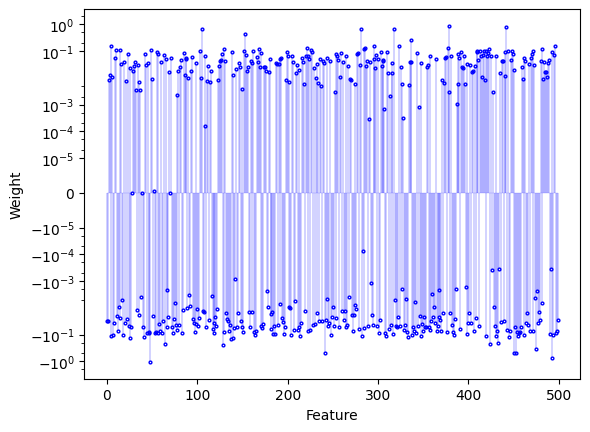

In [102]:
reg_coef.value = 1e-4
problem.solve()
print(f'Loss at optimum = {loss.value:.4g}')
cvxpy_coef_small_reg = coef.value.copy()
plot_coefficients(cvxpy_coef_small_reg)

Loss at optimum = 0.6188


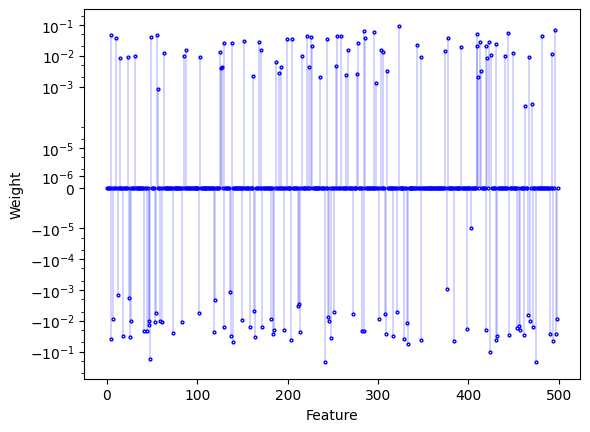

In [103]:
reg_coef.value = 1e-2
problem.solve()
print(f'Loss at optimum = {loss.value:.4g}')
cvxpy_sparse_coefs = coef.value.copy()
plot_coefficients(cvxpy_sparse_coefs)

## Train with Hadamard parameterization

In [104]:
class HadamardParametrization(torch.nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.v = torch.nn.Parameter(torch.ones(out_features, in_features))

  def forward(self, u):
    return u * self.v

In [105]:
layer = torch.nn.Linear(8, 1)
torch.nn.utils.parametrize.register_parametrization(layer, 'weight', HadamardParametrization(8, 1))
for name, param in layer.named_parameters():
  print(name, ': ', param)

bias :  Parameter containing:
tensor([0.0296], requires_grad=True)
parametrizations.weight.original :  Parameter containing:
tensor([[ 0.3156,  0.2912, -0.1510, -0.0658,  0.0374,  0.1545,  0.0853, -0.3527]],
       requires_grad=True)
parametrizations.weight.0.v :  Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)


In [106]:
print(layer.weight)

tensor([[ 0.3156,  0.2912, -0.1510, -0.0658,  0.0374,  0.1545,  0.0853, -0.3527]],
       grad_fn=<MulBackward0>)


In [107]:
from tqdm import trange

def train_model(dataset, model, criterion, optimizer, n_epochs=500, batch_size=8):
  epoch_losses = []
  for epoch in trange(n_epochs):
    epoch_loss = 0.
    for batch, batch_label in torch.utils.data.DataLoader(dataset, batch_size=batch_size):
      # compute predictiopn and loss
      batch_pred = model(batch)
      loss = criterion(batch_pred, batch_label)
      epoch_loss += loss.item() * torch.numel(batch_label)

      # invoke the optimizer using the gradients.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    epoch_losses.append(epoch_loss / len(dataset))
  return epoch_losses

In [108]:
def plot_convergence(epoch_losses, ax=None):
  if ax is None:
    ax = plt.gca()

  ax.set_xlabel('Epoch')
  ax.set_ylabel('Cost')
  ax.plot(epoch_losses)
  ax.set_yscale('log')
  last_iterate_loss = epoch_losses[-1]
  ax.axhline(last_iterate_loss, color='r', linestyle='--')
  ax.text(len(epoch_losses) / 2, last_iterate_loss, f'{last_iterate_loss:.4g}',
          fontsize=12, va='center', ha='center', backgroundcolor='w')

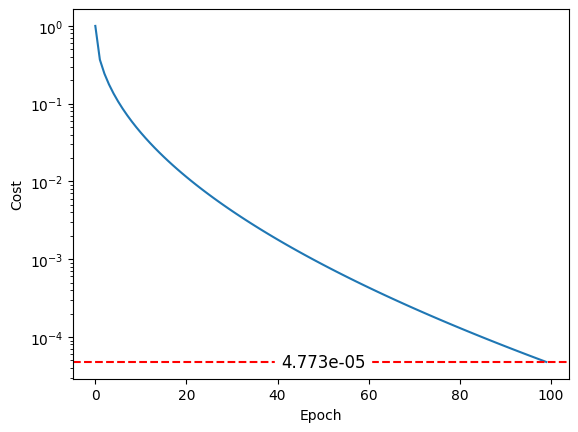

In [109]:
plot_convergence(np.exp(-np.sqrt(np.arange(100))))

In [110]:
def plot_training_results(model, losses, ref_coefs):
  # create figure and decorate axis labels
  fig, (ax_conv, ax_coefs) = plt.subplots(1, 2, figsize=(12, 4))
  plot_coefficients(ref_coefs, ax_coefs, color='blue', label='Reference')
  plot_coefficients(model.weight.ravel().detach().numpy(), ax_coefs, color='orange', label='Hadamard')
  ax_coefs.legend()
  plot_convergence(losses, ax_conv)
  plt.tight_layout()
  plt.show()

In [111]:
import torch.nn.utils.parametrize

def train_parameterized_model(alpha, optimizer_fn, ref_coefs, **train_kwargs):
  model_shape = (scaled_data.shape[1], 1)
  model = torch.nn.Linear(*model_shape)
  torch.nn.utils.parametrize.register_parametrization(
      model, 'weight', HadamardParametrization(*model_shape))

  dataset = torch.utils.data.TensorDataset(
      torch.as_tensor(scaled_data).float(),
      torch.as_tensor(labels).float().unsqueeze(1))
  criterion = torch.nn.BCEWithLogitsLoss()
  optimizer = optimizer_fn(model.parameters(), weight_decay=alpha)
  epoch_losses = train_model(dataset, model, criterion, optimizer, **train_kwargs)

  plot_training_results(model, epoch_losses, ref_coefs)

100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


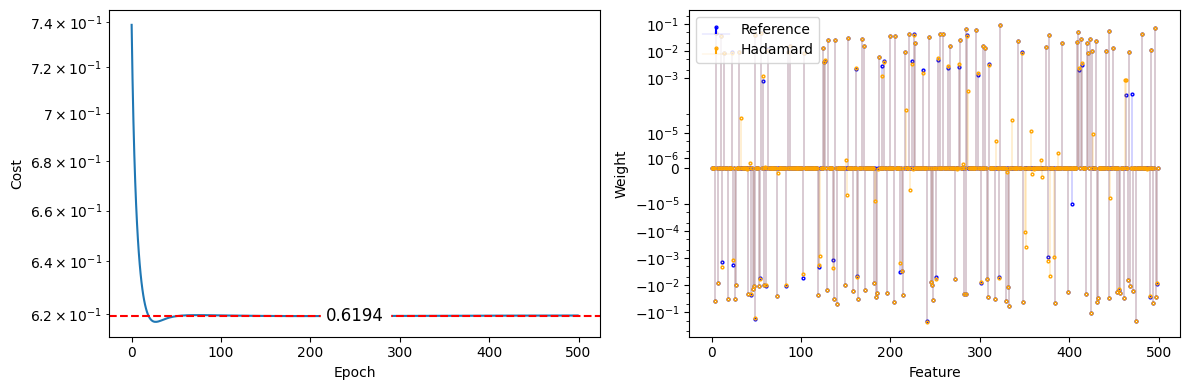

In [112]:
from functools import partial

train_parameterized_model(alpha=1e-2,
                          optimizer_fn=partial(torch.optim.Adam, lr=1e-4),
                          ref_coefs=cvxpy_sparse_coefs)

# Larger dataset, a neural network

## Prepare data

In [113]:
import pandas as pd

In [114]:
train_df = pd.read_csv('sample_data/california_housing_train.csv')
test_df = pd.read_csv('sample_data/california_housing_test.csv')

In [115]:
print(train_df.head().to_markdown(index=False))

|   longitude |   latitude |   housing_median_age |   total_rooms |   total_bedrooms |   population |   households |   median_income |   median_house_value |
|------------:|-----------:|---------------------:|--------------:|-----------------:|-------------:|-------------:|----------------:|---------------------:|
|     -114.31 |      34.19 |                   15 |          5612 |             1283 |         1015 |          472 |          1.4936 |                66900 |
|     -114.47 |      34.4  |                   19 |          7650 |             1901 |         1129 |          463 |          1.82   |                80100 |
|     -114.56 |      33.69 |                   17 |           720 |              174 |          333 |          117 |          1.6509 |                85700 |
|     -114.57 |      33.64 |                   14 |          1501 |              337 |          515 |          226 |          3.1917 |                73400 |
|     -114.57 |      33.57 |                   20 | 

In [116]:
scaler = StandardScaler().fit(train_df)
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)

In [117]:
train_ds = torch.utils.data.TensorDataset(
    torch.as_tensor(train_scaled[:, :-1]).float(),
    torch.as_tensor(train_scaled[:, -1]).float().unsqueeze(1))
test_features = torch.as_tensor(test_scaled[:, :-1]).float()
test_labels = torch.as_tensor(test_scaled[:, -1]).float().unsqueeze(1)

## Define components and parameterizations

In [118]:
class InputsHadamardParametrization(torch.nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.v = torch.nn.Parameter(torch.ones(1, in_features))

  def forward(self, u):
    return u * self.v

In [119]:
class Network(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = torch.nn.Linear(8, 32)
    self.fc2 = torch.nn.Linear(32, 64)
    self.fc3 = torch.nn.Linear(64, 32)
    self.fc4 = torch.nn.Linear(32, 1)
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.fc4(x)
    return x

  def linear_layers(self):
    return [self.fc1, self.fc2, self.fc3, self.fc4]

In [120]:
import torchinfo

network = Network()
torchinfo.summary(network, input_size=(1, 8))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 1]                    --
├─Linear: 1-1                            [1, 32]                   288
├─ReLU: 1-2                              [1, 32]                   --
├─Linear: 1-3                            [1, 64]                   2,112
├─ReLU: 1-4                              [1, 64]                   --
├─Linear: 1-5                            [1, 32]                   2,080
├─ReLU: 1-6                              [1, 32]                   --
├─Linear: 1-7                            [1, 1]                    33
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

In [121]:
def parametrize_neuron_inputs(network):
  for layer in network.linear_layers():
    num_inputs = layer.weight.shape[1]
    torch.nn.utils.parametrize.register_parametrization(
        layer, 'weight', InputsHadamardParametrization(num_inputs))

In [123]:
parametrize_neuron_inputs(network)
epoch_costs = train_model(train_ds, network, torch.nn.MSELoss(),
                          n_epochs=200, batch_size=128,
                          optimizer=torch.optim.Adam(network.parameters(), lr=0.002, weight_decay=0.001))

8
32
64
32


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


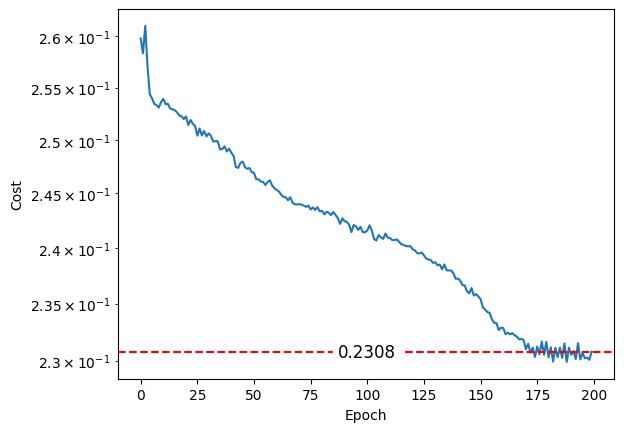

In [124]:
plot_convergence(epoch_costs)

In [125]:
def eval_network(network):
  network.eval()
  criterion = torch.nn.MSELoss()
  print(f'Test loss = {criterion(network(test_features), test_labels):.4g}')

eval_network(network)

Test loss = 0.3097


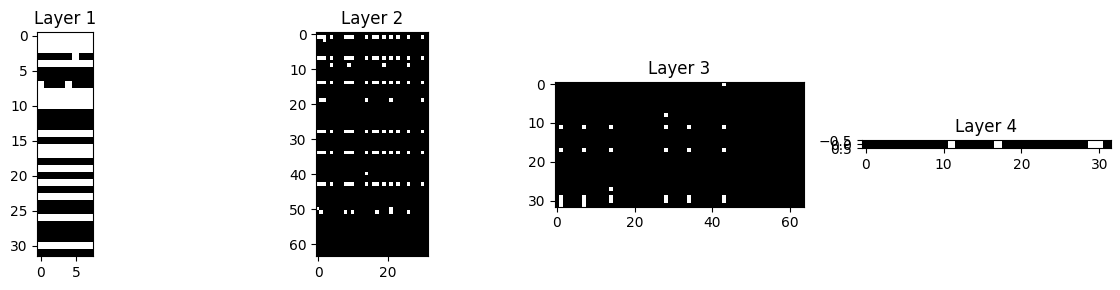

In [126]:
def plot_network(network, zero_threshold=1e-5):
  fig, axs = plt.subplots(1, 4, figsize=(12, 3))
  layers = network.linear_layers()

  for i, (ax, layer) in enumerate(zip(axs.ravel(), layers), start=1):
    layer_weights = layer.weight.abs().detach().numpy()
    image = layer.weight.abs().detach().numpy() > zero_threshold
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Layer {i}')
  plt.tight_layout()
  plt.show()

plot_network(network)

In [127]:
@torch.no_grad()
def shrink_linear_layer(layer, input_mask, threshold=1e-6):
  # compute mask of nonzero output neurons
  output_norms = torch.linalg.vector_norm(layer.weight, ord=1, dim=1)
  if layer.bias is not None:
    output_norms += layer.bias.abs()
  output_mask = output_norms > threshold

  # compute shrunk sizes
  in_features = torch.sum(input_mask).item()
  out_features = torch.sum(output_mask).item()

  # create a new shrunk layer
  has_bias = layer.bias is not None
  shrunk_layer = torch.nn.Linear(in_features, out_features, bias=has_bias)
  shrunk_layer.weight.set_(layer.weight[output_mask][:, input_mask])
  if has_bias:
    shrunk_layer.bias.set_(layer.bias[output_mask])
  return shrunk_layer, output_mask

In [128]:
mask = torch.ones(8, dtype=bool)
network.fc1, mask = shrink_linear_layer(network.fc1, mask)
network.fc2, mask = shrink_linear_layer(network.fc2, mask)
network.fc3, mask = shrink_linear_layer(network.fc3, mask)
network.fc4, mask = shrink_linear_layer(network.fc4, mask)
torchinfo.summary(network, input_size=(1, 8))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 1]                    --
├─Linear: 1-1                            [1, 18]                   162
├─ReLU: 1-2                              [1, 18]                   --
├─Linear: 1-3                            [1, 15]                   285
├─ReLU: 1-4                              [1, 15]                   --
├─Linear: 1-5                            [1, 9]                    144
├─ReLU: 1-6                              [1, 9]                    --
├─Linear: 1-7                            [1, 1]                    10
Total params: 601
Trainable params: 601
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


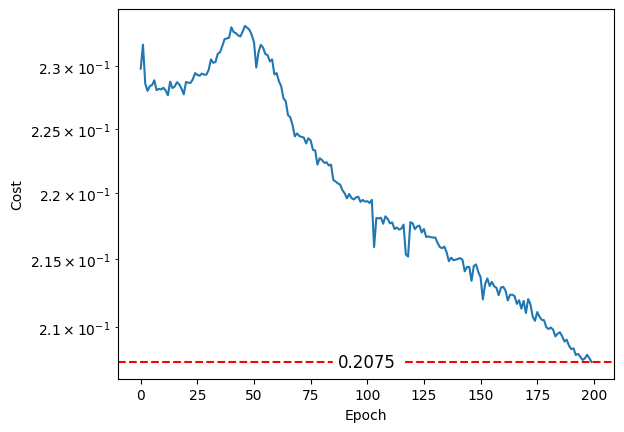

In [129]:
epoch_costs = train_model(train_ds, network, torch.nn.MSELoss(),
                          n_epochs=200, batch_size=128,
                          optimizer=torch.optim.Adam(network.parameters(), lr=0.002, weight_decay=1e-6))
plot_convergence(epoch_costs)

In [130]:
eval_network(network)

Test loss = 0.2385
